# Prophet non-saturating growth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline


$$ g(t)=\left(k+\mathbf{a}(t)^{\top} \boldsymbol{\delta}\right) t+\left(m+\mathbf{a}(t)^{\top} \boldsymbol{\gamma}\right) $$

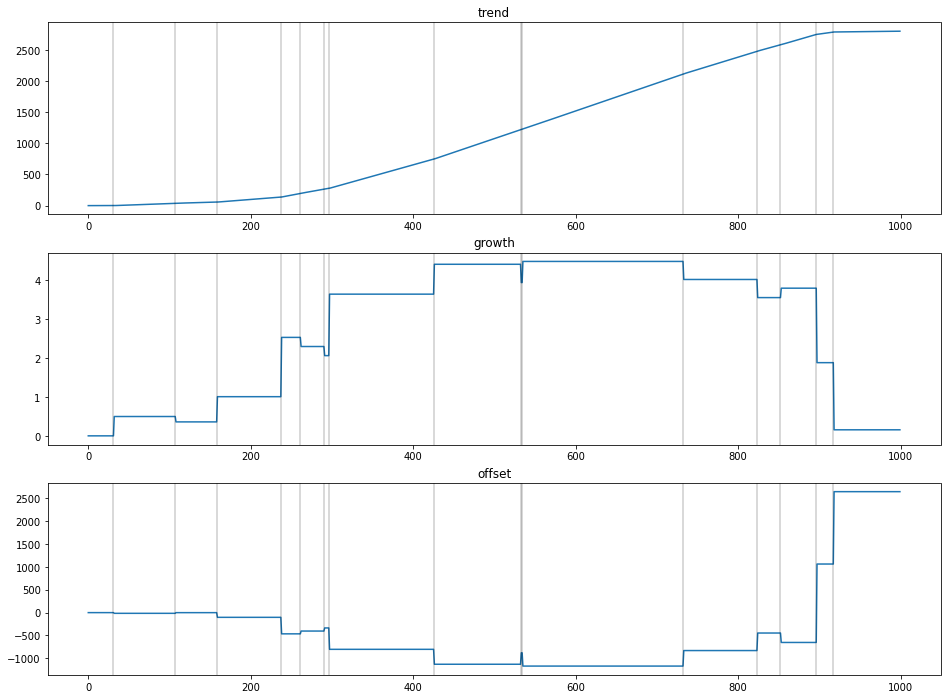

In [2]:

np.random.seed(42)

n_changepoints = 15
delta = np.random.normal(size=n_changepoints)

t = np.arange(1000)
s = np.sort(np.random.choice(t, n_changepoints, replace=False))


A = (t[:, None] > s) * 1

k, m = 0, 0

growth = (k + A @ delta)
gamma = -s * delta
offset = m + A @ gamma
trend = growth * t + offset

fig, (ax_u, ax_m, ax_l) = plt.subplots(figsize=(16, 12), nrows=3)
ax_u.set_title('trend')
ax_u.plot(trend)

ax_m.set_title('growth')
ax_m.plot(growth)

ax_l.set_title('offset')
ax_l.plot(offset)

for point in s:
    ax_u.axvline(point, c='k', alpha=0.2)
    ax_m.axvline(point, c='k', alpha=0.2)
    ax_l.axvline(point, c='k', alpha=0.2)


In [ ]:
import pymc3 as pm
import theano
import theano.tensor as tt

n_changepoints=24
changepoints_prior_scale=0.05
growth_prior_scale=1
t = np.arange(len(trend)) / len(trend)
s = np.linspace(0, np.max(t), n_changepoints + 1)[1:]

trend_scaled = trend / trend.max()


def dot(a, b):
    return (a * b[None, :]).sum(axis=-1)

with pm.Model() as model:
    A = (t[:, None] > s) * 1.
    # initial growth
    k = pm.Normal('k', 0 , growth_prior_scale)

    # rate of change
    delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
    # offset 
    m = pm.Normal('m', 0, 5)
    gamma = -s * delta

    g = (k + dot(A, delta)) * t + (m + dot(A, gamma))

    sigma = pm.HalfCauchy('sigma', 0.5)
    pm.Normal('obs', 
                 mu=g,
                 sd=sigma,
                 observed=trend_scaled)

    
    trace = pm.sample(tune=1000, cores=6, chains=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma, m, delta, k]
Sampling 6 chains, 0 divergences:  37%|███▋      | 3367/9000 [03:28<19:46,  4.75draws/s] 